<h1 style="text-align:center;"><b>Laboratorio 6</b></h1>
<h3 style="text-align:center;">Alina Carías (22539), Ariela Mishaan (22052), Marcos Díaz (221102) </h3>

# Librerías

In [45]:
import pandas as pd
import json
import unicodedata
import string
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import networkx as nx
import random

import community as community_louvain 
import collections
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from itertools import count


# ----- Análisis de tópicos con LDA (sklearn) -----
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 1. Carga de datos

## Tweets

In [46]:
with open("lab - datos redes/tioberny.txt", "r", encoding="utf-16") as f:
    tweetstxt = [json.loads(line) for line in f]

data = []
for t in tweetstxt:
    data.append({
        #"id": t.get("id"),
        "fecha": t.get("date"),
        "usuario": t["user"]["username"] if "user" in t else None,
        "nombre": t["user"]["displayname"] if "user" in t else None,
        "texto": t.get("rawContent"),
        "likes": t.get("likeCount"),
        "hashtags": t.get("hashtags"),
        #"mentioned": t.get("mentionedUsers"),
        "viewcount": t.get("viewCount"),
        "retweets": t.get("retweetCount"),
        "replies": t.get("replyCount"),
        "quotes": t.get("quoteCount")
        #"url": t.get("url")
    })

tweets = pd.DataFrame(data)
tweets.head()

,fecha,usuario,nombre,texto,likes,hashtags,viewcount,retweets,replies,quotes
0,2024-09-12 17:21:03+00:00,La_ReVoluZzion,The_ReVoluZZzioN 🫡,"_\nConfirmado Compañeres,\n\nEl impuesto por la @usembassyguate,\n—Solo cuenta con el pagado apoyo de los @48CantonesToto a través de la @USAIDGuate y @UEGuatemala\n\n@BArevalodeLeon huye y se esconde del Verdadero Pueblo Guatemalteco.",0,[],NaN,0,0,0
1,2024-09-12 15:27:20+00:00,XelaNewsGt,XelaNews,"#URGENTE Lo que los medios #faferos no informaron ayer, acerca de la visita del presidente #BernardoArévalo a #NebajQuiché, donde fue sacado a toda prisa por #SAAS ya que manifestantes pedían ser escuchados por el mandatario, quien decidió huir de esta manera.\n#XelaNews 🇫🇷 https://t.co/UQQbnvlfTa",142,"[URGENTE, faferos, BernardoArévalo, NebajQuiché, SAAS, XelaNews]",5200.0,80,12,15
2,2024-09-12 17:20:25+00:00,M24095273,VIVAlafuenteDEtodaVIDA,"@IvanDuque @BArevalodeLeon Con que usaste PEGASUS para espiar a tus detractores! obra de un narcisista sin conciencia, buena pinta por fuera corazon negro y podrido por dentro sin alma",0,[],NaN,0,0,0
3,2024-09-12 17:18:48+00:00,carlosalbesc,Carlos Alberto Escobar,"@IvanDuque @BArevalodeLeon Entre Ellos se entienden bien, y sÍ están cuadrando una ""PRODUCTIVA""reunión.",0,[],NaN,0,0,0
4,2024-09-12 17:16:42+00:00,Brenda_AGN,Brenda Lari,El presidente @BArevalodeLeon y la vicepresidenta @KarinHerreraVP participan en la Sesión Solemne en Conmemoración del 203 Aniversario de la Independencia de la República de Guatemala.\n\n@AGN_noticias\n@CongresoGuate https://t.co/zw3c2EqgK7,0,[],7.0,0,0,0


## Usuarios

In [47]:
user_data = {}
for t in tweetstxt:
    if "user" in t:
        u = t["user"]
        user_data[u["id"]] = {
            #"usuario_id": u["id"],
            "username": u.get("username"),
            "nombre": u.get("displayname"),
            "descripcion": u.get("rawDescription"),
            "creado_en": u.get("created"),
            "followers": u.get("followersCount"),
            "friends": u.get("friendsCount"),
            "tweets_totales": u.get("statusesCount"),
            "favourites": u.get("favouritesCount"),
            #"location": u.get("location"),
            #"url": u.get("url"),
            #"verified": u.get("verified"),
            #"profile_image": u.get("profileImageUrl"),
            #"profile_banner": u.get("profileBannerUrl")
        }

df_users = pd.DataFrame(list(user_data.values()))
df_users.head()

,username,nombre,descripcion,creado_en,followers,friends,tweets_totales,favourites
0,La_ReVoluZzion,The_ReVoluZZzioN 🫡,"¡Defensor de los defensores de los DDHH, PRO-LGBTIXXX🏳️‍🌈 y demás sub especies!",2021-09-07 02:11:21+00:00,2102,531,51984,143089
1,XelaNewsGt,XelaNews,Noticias sin injerencias.,2018-01-25 22:11:34+00:00,3462,359,2915,5719
2,M24095273,VIVAlafuenteDEtodaVIDA,CONCIENCIA TOTAL,2019-01-20 18:39:29+00:00,30,171,598,201
3,carlosalbesc,Carlos Alberto Escobar,,2014-11-17 13:58:10+00:00,11,218,4302,2817
4,Brenda_AGN,Brenda Lari,,2015-02-03 03:55:36+00:00,564,223,8707,4274


## Inspección inicial

In [48]:
tweets.info()
display(tweets.head())
tweets.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5019 entries, 0 to 5018
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fecha      5019 non-null   object 
 1   usuario    5019 non-null   object 
 2   nombre     5019 non-null   object 
 3   texto      5019 non-null   object 
 4   likes      5019 non-null   int64  
 5   hashtags   5019 non-null   object 
 6   viewcount  4938 non-null   float64
 7   retweets   5019 non-null   int64  
 8   replies    5019 non-null   int64  
 9   quotes     5019 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 392.2+ KB


,fecha,usuario,nombre,texto,likes,hashtags,viewcount,retweets,replies,quotes
0,2024-09-12 17:21:03+00:00,La_ReVoluZzion,The_ReVoluZZzioN 🫡,"_\nConfirmado Compañeres,\n\nEl impuesto por la @usembassyguate,\n—Solo cuenta con el pagado apoyo de los @48CantonesToto a través de la @USAIDGuate y @UEGuatemala\n\n@BArevalodeLeon huye y se esconde del Verdadero Pueblo Guatemalteco.",0,[],NaN,0,0,0
1,2024-09-12 15:27:20+00:00,XelaNewsGt,XelaNews,"#URGENTE Lo que los medios #faferos no informaron ayer, acerca de la visita del presidente #BernardoArévalo a #NebajQuiché, donde fue sacado a toda prisa por #SAAS ya que manifestantes pedían ser escuchados por el mandatario, quien decidió huir de esta manera.\n#XelaNews 🇫🇷 https://t.co/UQQbnvlfTa",142,"[URGENTE, faferos, BernardoArévalo, NebajQuiché, SAAS, XelaNews]",5200.0,80,12,15
2,2024-09-12 17:20:25+00:00,M24095273,VIVAlafuenteDEtodaVIDA,"@IvanDuque @BArevalodeLeon Con que usaste PEGASUS para espiar a tus detractores! obra de un narcisista sin conciencia, buena pinta por fuera corazon negro y podrido por dentro sin alma",0,[],NaN,0,0,0
3,2024-09-12 17:18:48+00:00,carlosalbesc,Carlos Alberto Escobar,"@IvanDuque @BArevalodeLeon Entre Ellos se entienden bien, y sÍ están cuadrando una ""PRODUCTIVA""reunión.",0,[],NaN,0,0,0
4,2024-09-12 17:16:42+00:00,Brenda_AGN,Brenda Lari,El presidente @BArevalodeLeon y la vicepresidenta @KarinHerreraVP participan en la Sesión Solemne en Conmemoración del 203 Aniversario de la Independencia de la República de Guatemala.\n\n@AGN_noticias\n@CongresoGuate https://t.co/zw3c2EqgK7,0,[],7.0,0,0,0


fecha         0
usuario       0
nombre        0
texto         0
likes         0
hashtags      0
viewcount    81
retweets      0
replies       0
quotes        0
dtype: int64

# 2. Limpieza y preprocesamiento

In [49]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

SPANISH_STOPWORDS = set(stopwords.words('spanish'))

In [50]:
# regex según acción por hacer
URL_RE = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)
MENTION_RE = re.compile(r'@([A-Za-z0-9_]{1,15})')  # handle básico de X
HASHTAG_RE = re.compile(r'#(\w+)')
EMOJI_RE = re.compile(r'[\U00010000-\U0010ffff]', flags=re.UNICODE)

In [51]:
# funciones para parsear cada item de cada tweet. 
def normalize_username(u):
    if pd.isna(u):
        return u
    return str(u).strip().lower()

def clean_text(text: str):
    if pd.isna(text):
        return ''
    t = text
    t = URL_RE.sub(' ', t)
    t = EMOJI_RE.sub(' ', t)
    t = t.lower()
    t = unicodedata.normalize('NFKD', t)
    t = ''.join(ch for ch in t if not unicodedata.combining(ch))
    t = t.translate(str.maketrans('', '', string.punctuation))
    t = re.sub(r'\d+', ' ', t)
    tokens = [w for w in re.findall(r'\b\w+\b', t) if w not in SPANISH_STOPWORDS]
    return ' '.join(tokens)

# devuelve una lista de todas las menciones (@) encontradas en el tweet. 
def extract_mentions(text: str):
    return [m.lower() for m in MENTION_RE.findall(text or '')]

# devuelve una lista de todos los hashtags (#) encontradas en el tweet. 
def extract_hashtags(text: str):
    return [h.lower() for h in HASHTAG_RE.findall(text or '')]

# si empieza con "rt" lo marca como retweet. 
def is_retweet(text: str):
    return bool(re.match(r'^\s*rt\s*@', str(text).lower()))

# si empieza con "@usuario" lo marca como reply. 
def is_reply(text: str):
    return bool(re.match(r'^\s*@', str(text).lower()))

In [52]:
tweets['username'] = tweets['usuario'].map(normalize_username)
tweets['tweet_text_clean'] = tweets['texto'].map(clean_text)
tweets['mentions'] = tweets['texto'].map(extract_mentions)
tweets['hashtags'] = tweets['texto'].map(extract_hashtags)
tweets['is_retweet'] = tweets['texto'].map(is_retweet)
tweets['is_reply'] = tweets['texto'].map(is_reply)
tweets['fecha'] = pd.to_datetime(tweets['fecha'], errors='coerce')

# Eliminar duplicados por texto y usuario en el mismo instante
tweets = tweets.drop_duplicates(subset=['username','texto','fecha']).reset_index(drop=True)
display(tweets.head())

,fecha,usuario,nombre,texto,likes,hashtags,viewcount,retweets,replies,quotes,username,tweet_text_clean,mentions,is_retweet,is_reply
0,2024-09-12 17:21:03+00:00,La_ReVoluZzion,The_ReVoluZZzioN 🫡,"_\nConfirmado Compañeres,\n\nEl impuesto por la @usembassyguate,\n—Solo cuenta con el pagado apoyo de los @48CantonesToto a través de la @USAIDGuate y @UEGuatemala\n\n@BArevalodeLeon huye y se esconde del Verdadero Pueblo Guatemalteco.",0,[],NaN,0,0,0,la_revoluzzion,confirmado companeres impuesto usembassyguate solo cuenta pagado apoyo cantonestoto traves usaidguate ueguatemala barevalodeleon huye esconde verdadero pueblo guatemalteco,"[usembassyguate, 48cantonestoto, usaidguate, ueguatemala, barevalodeleon]",False,False
1,2024-09-12 15:27:20+00:00,XelaNewsGt,XelaNews,"#URGENTE Lo que los medios #faferos no informaron ayer, acerca de la visita del presidente #BernardoArévalo a #NebajQuiché, donde fue sacado a toda prisa por #SAAS ya que manifestantes pedían ser escuchados por el mandatario, quien decidió huir de esta manera.\n#XelaNews 🇫🇷 https://t.co/UQQbnvlfTa",142,"[urgente, faferos, bernardoarévalo, nebajquiché, saas, xelanews]",5200.0,80,12,15,xelanewsgt,urgente medios faferos informaron ayer acerca visita presidente bernardoarevalo nebajquiche sacado toda prisa saas manifestantes pedian ser escuchados mandatario decidio huir manera xelanews,[],False,False
2,2024-09-12 17:20:25+00:00,M24095273,VIVAlafuenteDEtodaVIDA,"@IvanDuque @BArevalodeLeon Con que usaste PEGASUS para espiar a tus detractores! obra de un narcisista sin conciencia, buena pinta por fuera corazon negro y podrido por dentro sin alma",0,[],NaN,0,0,0,m24095273,ivanduque barevalodeleon usaste pegasus espiar detractores obra narcisista conciencia buena pinta corazon negro podrido dentro alma,"[ivanduque, barevalodeleon]",False,True
3,2024-09-12 17:18:48+00:00,carlosalbesc,Carlos Alberto Escobar,"@IvanDuque @BArevalodeLeon Entre Ellos se entienden bien, y sÍ están cuadrando una ""PRODUCTIVA""reunión.",0,[],NaN,0,0,0,carlosalbesc,ivanduque barevalodeleon entienden bien si estan cuadrando productivareunion,"[ivanduque, barevalodeleon]",False,True
4,2024-09-12 17:16:42+00:00,Brenda_AGN,Brenda Lari,El presidente @BArevalodeLeon y la vicepresidenta @KarinHerreraVP participan en la Sesión Solemne en Conmemoración del 203 Aniversario de la Independencia de la República de Guatemala.\n\n@AGN_noticias\n@CongresoGuate https://t.co/zw3c2EqgK7,0,[],7.0,0,0,0,brenda_agn,presidente barevalodeleon vicepresidenta karinherreravp participan sesion solemne conmemoracion aniversario independencia republica guatemala agnnoticias congresoguate,"[barevalodeleon, karinherreravp, agn_noticias, congresoguate]",False,False


In [53]:
pd.set_option("display.max_colwidth", None)
tweets[['texto', 'tweet_text_clean']].head(20)  

,texto,tweet_text_clean
0,"_\nConfirmado Compañeres,\n\nEl impuesto por la @usembassyguate,\n—Solo cuenta con el pagado apoyo de los @48CantonesToto a través de la @USAIDGuate y @UEGuatemala\n\n@BArevalodeLeon huye y se esconde del Verdadero Pueblo Guatemalteco.",confirmado companeres impuesto usembassyguate solo cuenta pagado apoyo cantonestoto traves usaidguate ueguatemala barevalodeleon huye esconde verdadero pueblo guatemalteco
1,"#URGENTE Lo que los medios #faferos no informaron ayer, acerca de la visita del presidente #BernardoArévalo a #NebajQuiché, donde fue sacado a toda prisa por #SAAS ya que manifestantes pedían ser escuchados por el mandatario, quien decidió huir de esta manera.\n#XelaNews 🇫🇷 https://t.co/UQQbnvlfTa",urgente medios faferos informaron ayer acerca visita presidente bernardoarevalo nebajquiche sacado toda prisa saas manifestantes pedian ser escuchados mandatario decidio huir manera xelanews
2,"@IvanDuque @BArevalodeLeon Con que usaste PEGASUS para espiar a tus detractores! obra de un narcisista sin conciencia, buena pinta por fuera corazon negro y podrido por dentro sin alma",ivanduque barevalodeleon usaste pegasus espiar detractores obra narcisista conciencia buena pinta corazon negro podrido dentro alma
3,"@IvanDuque @BArevalodeLeon Entre Ellos se entienden bien, y sÍ están cuadrando una ""PRODUCTIVA""reunión.",ivanduque barevalodeleon entienden bien si estan cuadrando productivareunion
4,El presidente @BArevalodeLeon y la vicepresidenta @KarinHerreraVP participan en la Sesión Solemne en Conmemoración del 203 Aniversario de la Independencia de la República de Guatemala.\n\n@AGN_noticias\n@CongresoGuate https://t.co/zw3c2EqgK7,presidente barevalodeleon vicepresidenta karinherreravp participan sesion solemne conmemoracion aniversario independencia republica guatemala agnnoticias congresoguate
5,@BArevalodeLeon El muy hijo de puta inyectó con enfermedades venereas a Guatemaltecos.,barevalodeleon hijo puta inyecto enfermedades venereas guatemaltecos
6,@EmisorasUnidas @BArevalodeLeon Y que de bueno le trae a Guatemala eso??,emisorasunidas barevalodeleon bueno trae guatemala
7,"@IvanDuque @BArevalodeLeon Productiva es que genere algo productivo y una charla sin nada que construya algo real no es para nada productivo, más bien es algo similar a unas viejas chismosas hablando de temas random",ivanduque barevalodeleon productiva genere productivo charla construya real productivo mas bien similar unas viejas chismosas hablando temas random
8,"@KarinHerreraVP El presidente de la República, @BArevalodeLeon, hace su ingreso al hemiciclo del Legislativo para participar en la sesión solemne en conmemoración de un aniversario más de la independencia del país. https://t.co/8x3ByTeAMN",karinherreravp presidente republica barevalodeleon hace ingreso hemiciclo legislativo participar sesion solemne conmemoracion aniversario mas independencia pais
9,"@mys_servicios @BArevalodeLeon No tampoco, ese izmierda también se cago en Guatemala o no se recuerdan de los experimentos en Guatemaltecos",mysservicios barevalodeleon tampoco izmierda tambien cago guatemala recuerdan experimentos guatemaltecos


# 3. Análisis exploratorio (EDA)

In [54]:
num_tweets = len(tweets)
num_usuarios = tweets['username'].nunique()
num_menciones = tweets['mentions'].map(len).sum()
all_hashtags = [h for hs in tweets['hashtags'] for h in hs]
num_hashtags = len(all_hashtags)

print('Tweets:', num_tweets)
print('Usuarios únicos:', num_usuarios)
print('Total de menciones:', num_menciones)
print('Total de hashtags:', num_hashtags)

top_mentions = Counter([m for ms in tweets['mentions'] for m in ms]).most_common(10)
top_hashtags = Counter(all_hashtags).most_common(10)
print('\nTop menciones:', top_mentions)
print('Top hashtags:', top_hashtags)

Tweets: 4944
Usuarios únicos: 2620
Total de menciones: 17220
Total de hashtags: 390

Top menciones: [('barevalodeleon', 4793), ('guatemalagob', 912), ('ubaldomacu', 573), ('santipalomov', 524), ('mpguatemala', 466), ('fjimenezmingob', 403), ('mingobguate', 288), ('__vadertg', 272), ('congresoguate', 255), ('diariodeca', 219)]
Top hashtags: [('guatemalasaleadelante', 24), ('urgente', 17), ('minfinsaleadelante', 17), ('guatemala', 16), ('presupuesto2025', 14), ('unpresupuestoparalapoblación', 13), ('enelpaísdca', 12), ('nacionalesagn', 8), ('traficogt', 6), ('ahora', 6)]


## Nube de top palabras

In [55]:
mentions_flat = [m for ms in tweets['mentions'] for m in ms]
top_mentions = [m for m, _ in Counter(mentions_flat).most_common(10)]

custom_stopwords = set(STOPWORDS) | set(top_mentions) | {"si", "ma", "mas"} 
text_for_wc = ' '.join(tweets['tweet_text_clean'].tolist())

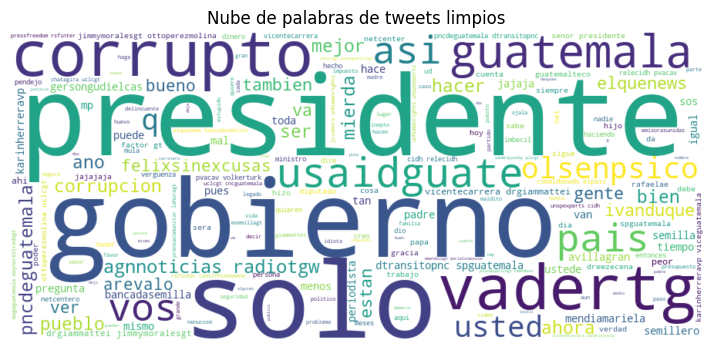

In [56]:
wc = WordCloud(
    width=900,
    height=400,
    background_color='white',
    stopwords=custom_stopwords
).generate(text_for_wc)
plt.figure(figsize=(10, 4))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de tweets limpios')
plt.show()

In [57]:
frecuencias = wc.words_
print(type(frecuencias))
print(list(frecuencias.items())[:10])

<class 'dict'>
[('presidente', 1.0), ('gobierno', 0.924924924924925), ('solo', 0.9129129129129129), ('corrupto', 0.6906906906906907), ('vadertg', 0.6546546546546547), ('guatemala', 0.6396396396396397), ('usaidguate', 0.6306306306306306), ('asi', 0.5495495495495496), ('vos', 0.5405405405405406), ('pais', 0.5375375375375375)]


## Preguntas

### ¿Qué hashtags dominan la conversación?

In [58]:
all_hashtags = [h for hs in tweets['hashtags'] for h in hs]
hashtag_counts = Counter(all_hashtags)

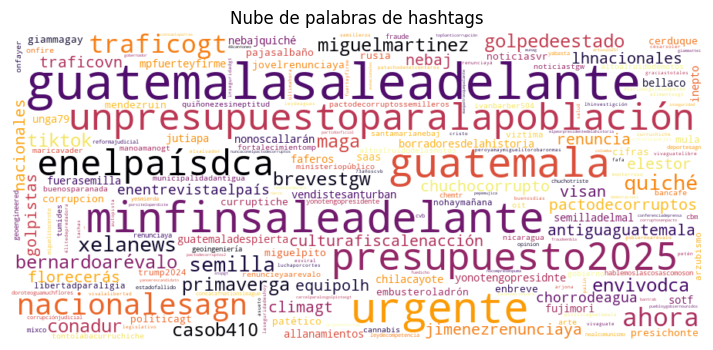

In [59]:
wc_hashtags = WordCloud(
    width=900,
    height=400,
    background_color='white',
    colormap='inferno' 
).generate_from_frequencies(hashtag_counts)
plt.figure(figsize=(10, 4))
plt.imshow(wc_hashtags, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de hashtags')
plt.show()

### ¿Cuáles son las cuentas más mencionadas?

In [60]:
all_mentions = [m for ms in tweets['mentions'] for m in ms]
mention_counts = Counter(all_mentions)

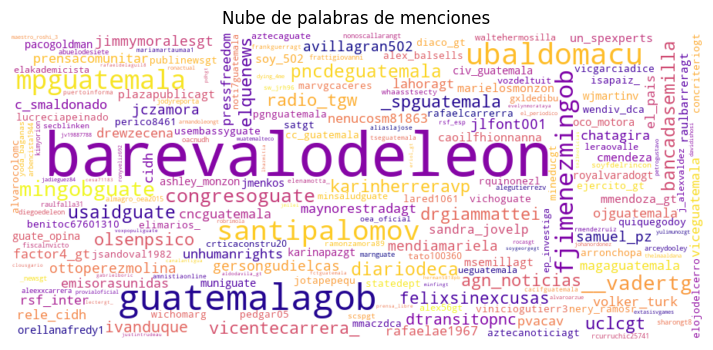

In [61]:
wc_mentions = WordCloud(
    width=900,
    height=400,
    background_color='white',
    colormap='plasma'  
).generate_from_frequencies(mention_counts)
plt.figure(figsize=(10, 4))
plt.imshow(wc_mentions, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de menciones')
plt.show()

### ¿Qué horarios concentran mpas actividad segun `tiempo_de_publicado`?

In [62]:
activity = (
    tweets.dropna(subset=['fecha'])
    .assign(hour=lambda d: d['fecha'].dt.hour)
    .groupby('hour')['texto']
    .count()
    .reset_index(name='tweets')
)
activity

,hour,tweets
0,0,301
1,1,261
2,2,226
3,3,186
4,4,165
5,5,143
6,6,89
7,7,33
8,8,17
9,9,13


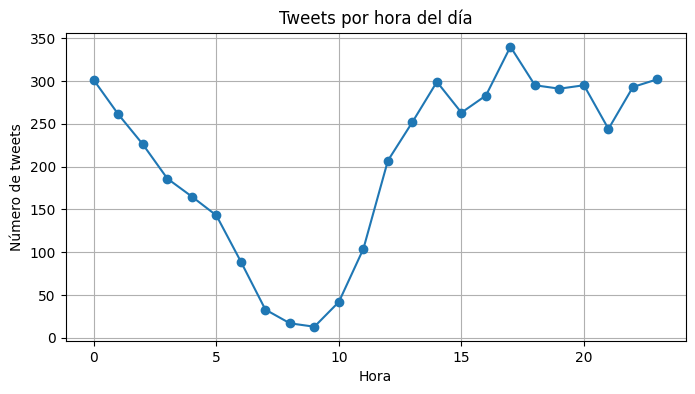

In [63]:
plt.figure(figsize=(8,4))
plt.plot(activity['hour'], activity['tweets'], marker='o')
plt.title('Tweets por hora del día')
plt.xlabel('Hora')
plt.ylabel('Número de tweets')
plt.grid(True)
plt.show()

### ¿Cuáles son los tweets con más retweets?

In [64]:
top10 = (tweets.sort_values('retweets', ascending=False)
            .loc[:, ['tweet_text_clean','retweets']]
            .head(10))

with pd.option_context('display.max_colwidth', None):
    display(
        top10.style.set_properties(
            **{'white-space': 'pre-wrap',
            'text-align': 'left'}
        , subset=['tweet_text_clean'])
    )


,tweet_text_clean,retweets
2820,domingo hs presentare congreso nacion argentina presupuesto nacional bajo regla deficit cero invito ser testigo hito historico marcara despues historia economica argentina viva libertad carajo,8307
4364,perfecto pensamos hace rato hace nayibbukele,6592
452,rechazo aumento gasto publico hoy heroes pusieron freno degenerados fiscales intentaron destruir superavit fiscal argentinos esfuerzo lograromos conseguir evidentemente politicos siguen pensando argentinos tontos vemos malintencionadas maniobras voltear gobierno primera vez elige decirle argentinos verdad incomoda lugar mentira confortable deficit cero innegociable viva libertad carajo,6336
2701,never knew hyenas could be this gentle,5221
3109,tratare contratar servicio especializado detecte rastros infeccion pegasus telefonos ciudadania toda persona sospechas infeccion ilegal telefono puede consultar pagina prestemos servicio gobierno pido jovenes cerca llamaron lideres juveniles desaparecidos muertos dertencion paro usen servicios,5203
4112,solo logramos captura nivel internacional sino gracias servicios inteligencia autoridades paises amigos evitamos largo complejo proceso extradicion entendio entendio,4685
3105,rampas camiones control estan disenadas usarse caso falla frenos asi funcionan,4570
49,imagen recorre mundo argentina milei duele,3223
1029,amlo aborrece norma pina segun corrupta hoy aplaude yunes molesta corrupcion importa corrupcion favor si odiar mexico,3016
1179,genialidad,2846


# 4. Construcción de la red dirigida

In [65]:
rows = [] # tuplas (source, target, type)
for _, r in tweets.iterrows():
    user = r['username']
    # Retweet: RT @alguien: ...  interpretamos como user -> alguien (tipo retweet)
    if r['is_retweet']:
        ms = extract_mentions(r['tweet'])
        if ms:
            rows.append((user, ms[0], 'retweet'))
    # Reply: si inicia con @alguien  interpretamos como user -> alguien (tipo reply)
    if r['is_reply']:
        ms = extract_mentions(r['texto'])
        if ms:
            rows.append((user, ms[0], 'reply'))
    # Mentions: todas las menciones (pueden coexistir con RT/reply)
    for m in r['mentions']:
        rows.append((user, m, 'mention'))

edges = pd.DataFrame(rows, columns=['source','target','type'])
edges = edges[edges['source'] != edges['target']].drop_duplicates().reset_index(drop=True)
edges.head()

,source,target,type
0,la_revoluzzion,usembassyguate,mention
1,la_revoluzzion,48cantonestoto,mention
2,la_revoluzzion,usaidguate,mention
3,la_revoluzzion,ueguatemala,mention
4,la_revoluzzion,barevalodeleon,mention


# 5. Topología

In [66]:
# armamos un grafo (de pandas dataframe (aristas) a grafo DIRIGIDO)
G = nx.from_pandas_edgelist(
    edges, source='source', target='target', create_using=nx.DiGraph()
)

print('Nodos:', G.number_of_nodes())
print('Aristas:', G.number_of_edges())

# Densidad
density = nx.density(G)
print('Densidad:', density)

# Diámetro: sobre el componente más grande (no definido si el grafo es disconexo)
if G.number_of_nodes() > 0:
    GCC_nodes = max(nx.weakly_connected_components(G), key=len)
    Gcc = G.subgraph(GCC_nodes).to_undirected()
    try:
        diameter = nx.diameter(Gcc)
    except nx.NetworkXError:
        diameter = np.nan
else:
    diameter = np.nan
print('Diámetro (componente mayor):', diameter)

# Coeficiente de agrupamiento (usamos versión no dirigida)
clustering = nx.average_clustering(G.to_undirected()) if G.number_of_nodes() > 0 else np.nan
print('Coeficiente de agrupamiento promedio:', clustering)

Nodos: 3115
Aristas: 12243
Densidad: 0.0012621506354051654
Diámetro (componente mayor): 6
Coeficiente de agrupamiento promedio: 0.3693694753822323


C:\Users\Alina Tatjana\AppData\Local\Temp\ipykernel_39076\413615682.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', np.unique(colors).size)


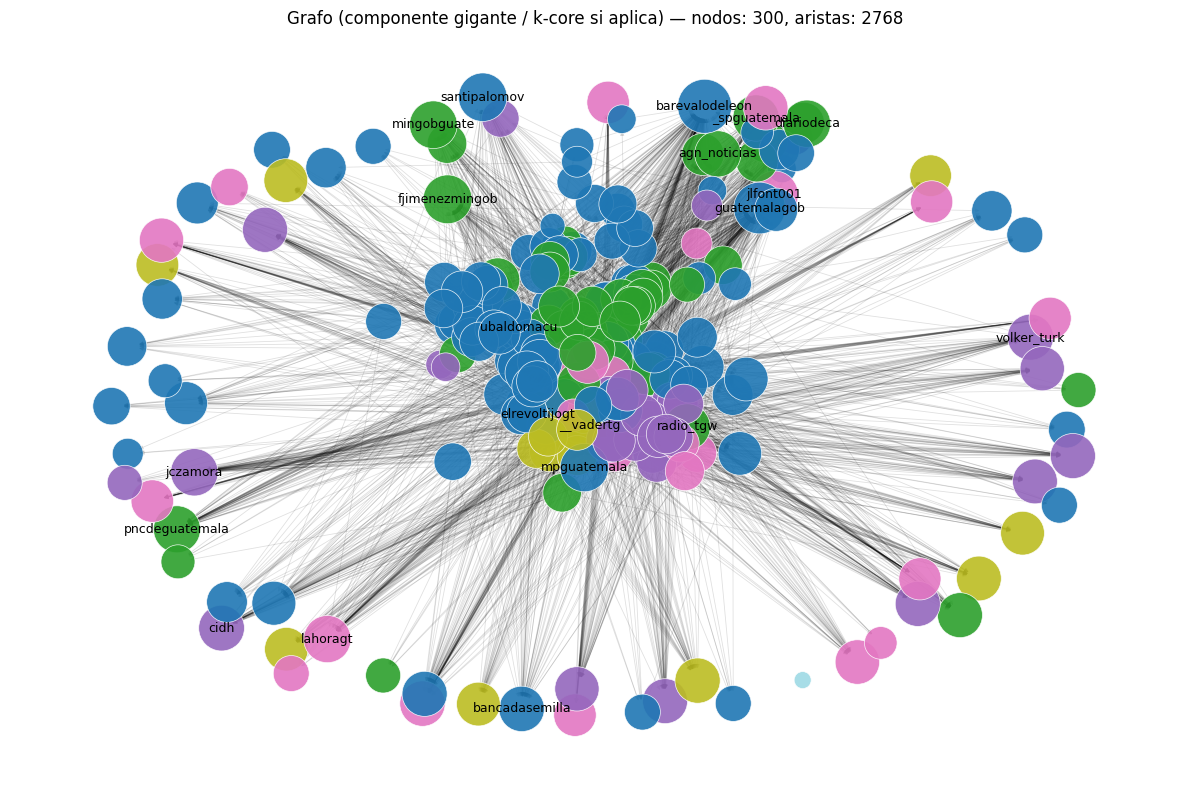

In [67]:
def plot_graph_pretty(G,
                    max_nodes=300,       
                    label_top=20,        
                    arrows=True,
                    seed=42):
    if G.number_of_nodes() == 0:
        print("Grafo vacío.")
        return
    GCC_nodes = max(nx.weakly_connected_components(G), key=len) if G.is_directed() \
                else max(nx.connected_components(G), key=len)
    H = G.subgraph(GCC_nodes).copy()

    H_und = H.to_undirected()
    n = H.number_of_nodes()
    if n > max_nodes:
        degrees = [d for _, d in H_und.degree()]
        k_max = int(np.percentile(degrees, 85)) 
        k_candidates = list(range(max(1, k_max), 0, -1))
        Hk = None
        for k in k_candidates:
            K = nx.k_core(H_und, k)
            if K.number_of_nodes() <= max_nodes and K.number_of_nodes() > 0:
                Hk = K
                break
        if Hk is None:
            top_nodes = [n for n, _ in sorted(H_und.degree(), key=lambda x: x[1], reverse=True)[:max_nodes]]
            Hk = H_und.subgraph(top_nodes).copy()
        H = H.subgraph(Hk.nodes()).copy()

    try:
        comms = list(nx.algorithms.community.greedy_modularity_communities(H.to_undirected()))
        comm_map = {}
        for cid, cset in enumerate(comms):
            for u in cset:
                comm_map[u] = cid
        colors = [comm_map.get(u, 0) for u in H.nodes()]
    except Exception:
        colors = None

    k = 1/np.sqrt(max(1, H.number_of_nodes()))
    pos = nx.spring_layout(H, seed=seed, k=3*k)

    deg = dict(H.degree())
    node_sizes = np.array([deg[u] for u in H.nodes()], dtype=float)
    node_sizes = 150 + 250 * np.log1p(node_sizes)

    plt.figure(figsize=(12, 8))
    if colors is not None:
        cmap = plt.cm.get_cmap('tab20', np.unique(colors).size)
        nx.draw_networkx_nodes(H, pos,
                            node_size=node_sizes,
                            node_color=colors,
                            cmap=cmap,
                            alpha=0.9,
                            linewidths=0.5,
                            edgecolors='white')
    else:
        nx.draw_networkx_nodes(H, pos,
                            node_size=node_sizes,
                            alpha=0.9,
                            linewidths=0.5,
                            edgecolors='white')

    edge_alpha = 0.12 if H.number_of_edges() > 2000 else 0.25
    nx.draw_networkx_edges(H, pos,
                        arrows=H.is_directed() and arrows,
                        arrowstyle='-|>',
                        arrowsize=6,
                        width=0.6,
                        alpha=edge_alpha)

    top_label_nodes = set([n for n, _ in sorted(deg.items(), key=lambda x: x[1], reverse=True)[:label_top]])
    labels = {n: str(n) for n in H.nodes() if n in top_label_nodes}
    nx.draw_networkx_labels(H, pos, labels=labels, font_size=9)

    plt.title(f'Grafo (componente gigante / k-core si aplica) — nodos: {H.number_of_nodes()}, aristas: {H.number_of_edges()}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_graph_pretty(G, max_nodes=300, label_top=20)


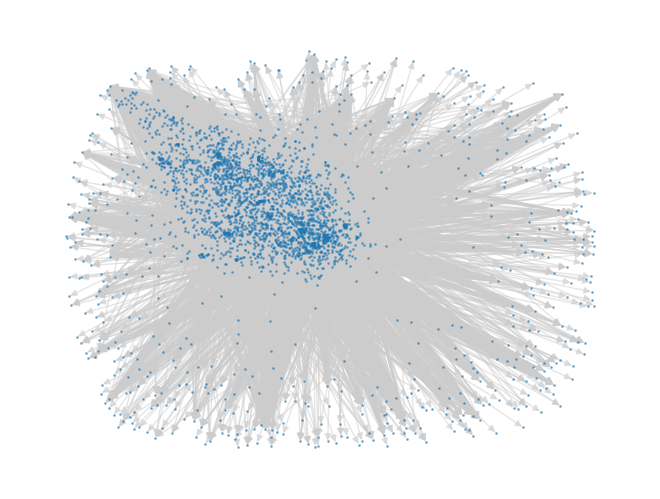

In [68]:
pos = nx.spring_layout(G, seed=42, iterations=10) 
nx.draw(G, pos, node_size=1, edge_color='#cccccc', alpha=0.5, with_labels=False)
plt.show()

# 6. Detección de comunidades

In [69]:
try:
    import community.community_louvain as community_louvain
except ImportError:
    community_louvain = None
    print('Instala python-louvain: pip install python-louvain')
    
if community_louvain:
    # Louvain trabaja con grafo no dirigido por defecto
    undirected = G.to_undirected()
    partition = community_louvain.best_partition(undirected, random_state=42)
    nx.set_node_attributes(G, partition, 'community')
    # Tamaños por comunidad
    counter = collections.Counter(partition.values())
    comm_sizes = pd.DataFrame(counter.items(), columns=['community','size']).sort_values('size', ascending=False)
    display(comm_sizes)
else:
    partition = {}
    comm_sizes = pd.DataFrame(columns=['community','size'])

,community,size
5,5,914
11,11,333
6,6,231
0,0,211
3,3,199
2,2,185
12,12,171
10,10,164
7,7,150
8,8,142


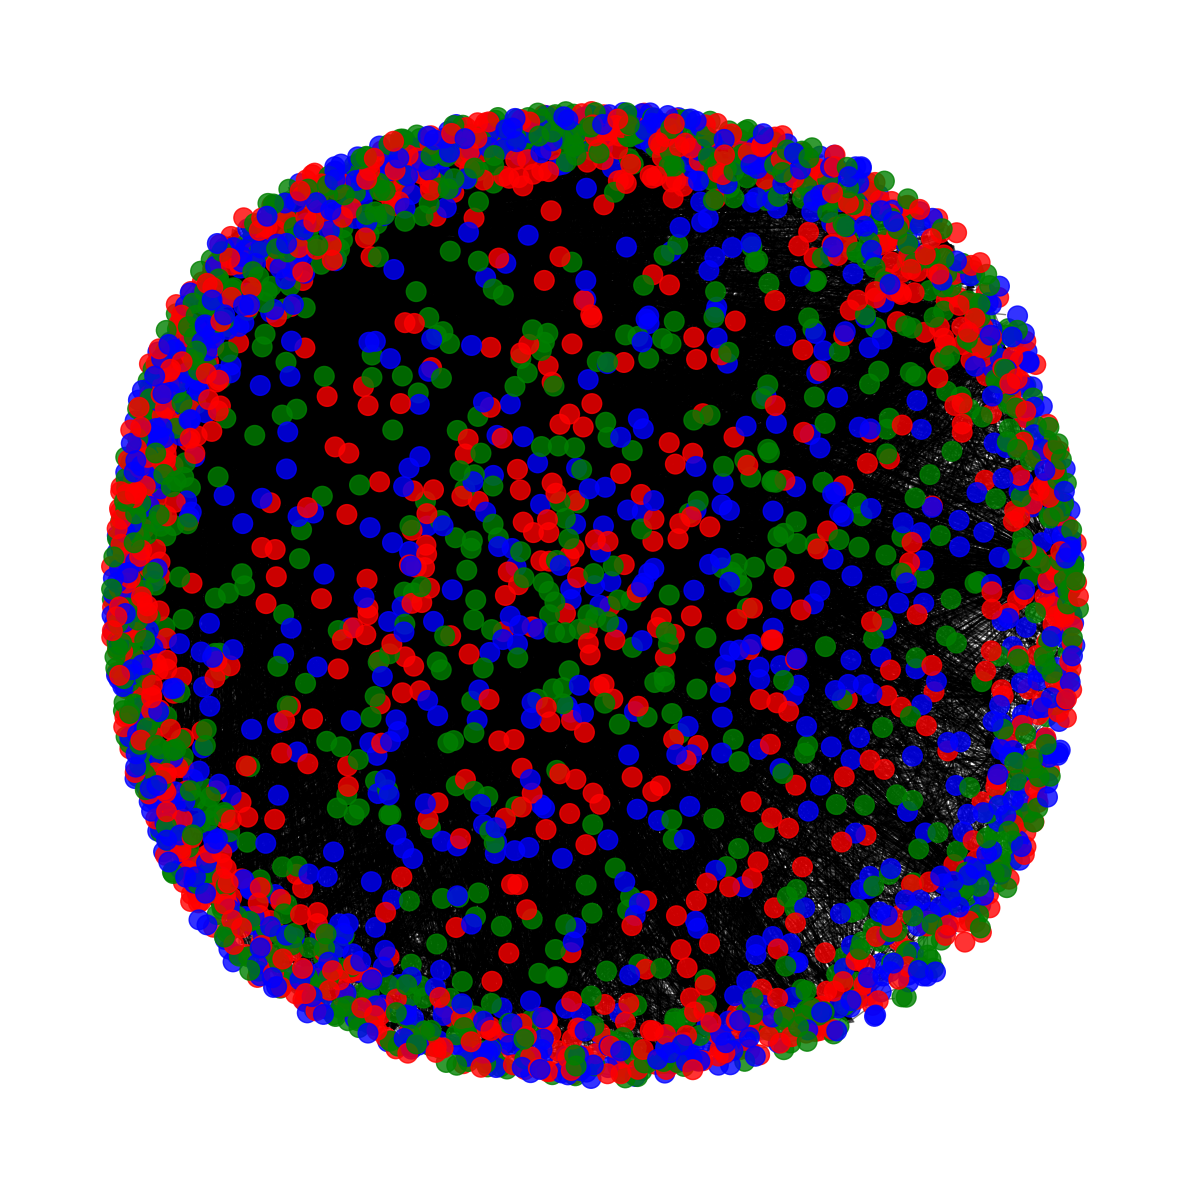

In [70]:
node_communities = {node: random.randint(0, 2) for node in G.nodes()} 

colors = ['red', 'green', 'blue']
node_color_map = [colors[node_communities[node]] for node in G.nodes()]
plt.figure(figsize=(12, 12)) 

pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42) 

nx.draw_networkx_nodes(G, pos, node_color=node_color_map, node_size=200, alpha=0.8) # Adjust node_size
nx.draw_networkx_edges(G, pos, alpha=0.5)

plt.axis('off')
plt.tight_layout()
plt.show()

# 7. Influencers y nodos clave

In [71]:
import numpy as np
import pandas as pd
import networkx as nx

if G.number_of_nodes() > 0:
    # Centralidades para grafos dirigidos
    cent_degree   = nx.degree_centrality(G)          # combina in+out
    cent_in       = nx.in_degree_centrality(G)       # solo entrantes
    cent_out      = nx.out_degree_centrality(G)      # solo salientes
    cent_between  = nx.betweenness_centrality(G)     # intermediación
    cent_closeness= nx.closeness_centrality(G.to_undirected())  
    # (usamos versión no dirigida para evitar problemas de accesibilidad)

    centralities = (
        pd.DataFrame({
            'node': list(G.nodes()),
            'degree':     [cent_degree.get(n,0) for n in G.nodes()],
            'in_degree':  [cent_in.get(n,0) for n in G.nodes()],
            'out_degree': [cent_out.get(n,0) for n in G.nodes()],
            'betweenness':[cent_between.get(n,0) for n in G.nodes()],
            'closeness':  [cent_closeness.get(n,0) for n in G.nodes()],
            'community':  [G.nodes[n].get('community', np.nan) for n in G.nodes()]
        })
        .sort_values(['degree','betweenness','closeness'], ascending=False,
                    ignore_index=True)
    )

    display(centralities.head(10))
else:
    centralities = pd.DataFrame(columns=['node','degree','in_degree',
                                        'out_degree','betweenness',
                                        'closeness','community'])
    display(centralities)


,node,degree,in_degree,out_degree,betweenness,closeness,community
0,barevalodeleon,0.809249,0.809249,0.000000,0.000000,0.836591,5
1,guatemalagob,0.197816,0.197174,0.000642,0.000420,0.526573,6
2,ubaldomacu,0.133911,0.130379,0.003532,0.013348,0.502362,11
3,santipalomov,0.118497,0.118497,0.000000,0.000000,0.385878,11
4,mpguatemala,0.107900,0.107579,0.000321,0.000131,0.381310,11
5,fjimenezmingob,0.089917,0.089274,0.000642,0.000175,0.389867,0
6,__vadertg,0.075466,0.068722,0.006744,0.004766,0.482528,3
7,congresoguate,0.070328,0.070328,0.000000,0.000000,0.357709,3
8,mingobguate,0.066474,0.066474,0.000000,0.000000,0.362915,0
9,usaidguate,0.060694,0.060051,0.000642,0.000143,0.379066,3


La red analizada muestra una fuerte centralización en torno a *barevalodeleon*, quien destaca por recibir la mayoría de menciones (degree e in_degree de 0.809), sin emitir conexiones (out_degree = 0), y por estar estratégicamente ubicado (closeness de 0.83) dentro de la comunidad 5. Otros nodos relevantes como *guatemalagob*, *ubaldomacu* y *santipalomov* presentan grados intermedios y cierta capacidad de intermediación, aunque los valores de betweenness son bajos en general, lo que indica que la red no depende de nodos puente para su conectividad. Los actores están distribuidos en comunidades diferenciadas, reflejando agrupaciones temáticas o institucionales, pero todas giran en torno al nodo dominante, lo que sugiere una estructura jerárquica con un centro claramente definido.

# 8. Análisis de grupos aislados

In [82]:
isolated_nodes = [n for n in G.nodes() if G.in_degree(n) == 0 and G.out_degree(n) == 0]
print(f"Nodos aislados (sin aristas): {len(isolated_nodes)}")
if len(isolated_nodes) > 0:
    display(pd.DataFrame({'node': isolated_nodes}).head(20))

Nodos aislados (sin aristas): 0


In [83]:
if G.number_of_nodes() > 0:
    comps = list(nx.weakly_connected_components(G))
    comps_sorted = sorted(comps, key=len, reverse=True)
    giant = comps_sorted[0] if comps_sorted else set()
    others = comps_sorted[1:] if len(comps_sorted) > 1 else []
    comp_rows = []

    for i, c in enumerate(comps_sorted):
        sub = G.subgraph(c).copy()
        comp_rows.append({
            'component_id': i,
            'nodes': sub.number_of_nodes(),
            'edges': sub.number_of_edges(),
            'density_ud': nx.density(sub.to_undirected()) if sub.number_of_nodes() > 1 else 0.0,
            'is_giant': (i == 0)
        })
    df_comps = pd.DataFrame(comp_rows).sort_values(['is_giant','nodes'], ascending=[False, False])
    print(f"Componentes débiles totales: {len(comps_sorted)}  |  Componente gigante: {len(giant)} nodos")
    display(df_comps.head(15))
    isolated_subnets = []

    for i, c in enumerate(others, start=1):
        sub = G.subgraph(c).copy()
        isolated_subnets.append({
            'component_id': i,
            'nodes': sub.number_of_nodes(),
            'edges': sub.number_of_edges(),
            'sample_nodes': list(sub.nodes())[:10]
        })
    df_isolated = pd.DataFrame(isolated_subnets).sort_values('nodes', ascending=False)
    print("Subredes aisladas (fuera de la gigante):", len(df_isolated))
    
    if not df_isolated.empty:
        display(df_isolated.head(10))
else:
    df_comps = pd.DataFrame(); df_isolated = pd.DataFrame()
    print("Grafo vacío.")

Componentes débiles totales: 6  |  Componente gigante: 3104 nodos


,component_id,nodes,edges,density_ud,is_giant
0,0,3104,12237,0.002515,True
1,1,3,2,0.666667,False
2,2,2,1,1.000000,False
3,3,2,1,1.000000,False
4,4,2,1,1.000000,False
5,5,2,1,1.000000,False


Subredes aisladas (fuera de la gigante): 5


,component_id,nodes,edges,sample_nodes
0,1,3,2,"[efraincepeda, senadogovco, isazuleta]"
1,2,2,1,"[inafinogenova, labase_tv]"
2,3,2,1,"[_hannahritchie, ourworldindata]"
3,4,2,1,"[betocoralg, youtube]"
4,5,2,1,"[cuxmigue, fedefut_oficial]"


In [86]:
try:
    import community.community_louvain as community_louvain
    have_louvain = True
except Exception:
    have_louvain = False
    print("Instala python-louvain para evaluar comunidades: pip install python-louvain")

def community_cut_stats(Gdir, partition_dict):
    comm2nodes = {}
    for n, c in partition_dict.items():
        comm2nodes.setdefault(c, set()).add(n)

    E = list(Gdir.edges())
    for cid, nodes_c in comm2nodes.items():
        nodes_out = set(Gdir.nodes()) - nodes_c
        internal = sum(1 for (u, v) in E if u in nodes_c and v in nodes_c)
        cut_out = sum(1 for (u, v) in E if u in nodes_c and v in nodes_out)  
        cut_in  = sum(1 for (u, v) in E if u in nodes_out and v in nodes_c)  # entran
        boundary = cut_in + cut_out

        size = len(nodes_c)
        # Conductancia (menor es "más aislada"): boundary / (2*internal + boundary)
        denom = 2*internal + boundary
        conductance = boundary/denom if denom > 0 else 0.0
        external_ratio = boundary / (internal + boundary) if (internal + boundary) > 0 else 0.0

        rows.append({
            'community': cid,
            'size': size,
            'internal_edges': internal,
            'boundary_edges': boundary,
            'cut_in': cut_in,
            'cut_out': cut_out,
            'external_ratio': external_ratio
        })
    return pd.DataFrame(rows)

In [88]:
import numpy as np
import pandas as pd
import networkx as nx

# --- helper: métricas por comunidad ---
def community_cut_stats(Gdir, partition_dict):
    """
    Devuelve un DataFrame con: community, size, internal_edges, boundary_edges,
    cut_in, cut_out, external_ratio, conductance.
    Funciona incluso con grafos con pocas aristas (devuelve 0.0 en divisiones vacías).
    """
    rows = []
    if not partition_dict:
        return pd.DataFrame(columns=[
            'community','size','internal_edges','boundary_edges',
            'cut_in','cut_out','external_ratio','conductance'
        ])

    # nodos por comunidad
    comm2nodes = {}
    for n, c in partition_dict.items():
        comm2nodes.setdefault(c, set()).add(n)

    E = list(Gdir.edges())
    for cid, S in comm2nodes.items():
        if len(S) == 0:
            continue
        S_out = set(Gdir.nodes()) - S

        internal = sum(1 for (u, v) in E if u in S and v in S)
        cut_out  = sum(1 for (u, v) in E if u in S and v in S_out)
        cut_in   = sum(1 for (u, v) in E if u in S_out and v in S)
        boundary = cut_in + cut_out

        denom = 2*internal + boundary
        conductance   = boundary/denom if denom > 0 else 0.0
        external_ratio = boundary/(internal+boundary) if (internal+boundary) > 0 else 0.0

        rows.append({
            'community': cid,
            'size': len(S),
            'internal_edges': internal,
            'boundary_edges': boundary,
            'cut_in': cut_in,
            'cut_out': cut_out,
            'external_ratio': external_ratio,
            'conductance': conductance
        })
    return pd.DataFrame(rows)

# --- Louvain + orden seguro ---
try:
    import community.community_louvain as community_louvain
    have_louvain = True
except Exception:
    have_louvain = False
    print("Instala python-louvain: pip install python-louvain")

if have_louvain and G.number_of_nodes() > 0:
    # Componente gigante para evitar “falsos aislados”
    GCC = max(nx.weakly_connected_components(G), key=len)
    H = G.subgraph(GCC).copy()

    # Partición Louvain sobre no dirigido
    part = community_louvain.best_partition(H.to_undirected(), random_state=42)
    nx.set_node_attributes(H, part, 'community')

    comm_stats = community_cut_stats(H, part)

    # Asegurar que las columnas existen (evita KeyError si DF viene vacío)
    for col in ['conductance', 'external_ratio', 'size']:
        if col not in comm_stats.columns:
            comm_stats[col] = np.nan

    if not comm_stats.empty:
        comm_stats = comm_stats.sort_values(
            ['conductance','external_ratio','size'],
            ascending=[True, True, False],
            ignore_index=True
        )
        print("Comunidades (más aisladas primero: menor conductance):")
        display(comm_stats.head(10))

        # Top-5 comunidades más aisladas: muestra algunos nodos
        top_isolated_cids = comm_stats.head(5)['community'].tolist()
        sample_rows = []
        for cid in top_isolated_cids:
            nodes_c = [n for n, c in part.items() if c == cid]
            sample_rows.append({'community': cid, 'size': len(nodes_c), 'sample_nodes': nodes_c[:15]})
        display(pd.DataFrame(sample_rows))
    else:
        print("No se pudieron calcular stats de comunidades (partición vacía o sin aristas suficientes).")
else:
    print("No se ejecutó Louvain (falta paquete o grafo vacío).")


Comunidades (más aisladas primero: menor conductance):


,community,size,internal_edges,boundary_edges,cut_in,cut_out,external_ratio,conductance
0,7,9,18,3,0,3,0.142857,0.076923
1,16,79,96,24,4,20,0.200000,0.111111
2,5,8,7,2,0,2,0.222222,0.125000
3,2,12,26,8,2,6,0.235294,0.133333
4,11,187,1017,726,212,514,0.416523,0.263043
5,3,199,594,508,149,359,0.460980,0.299528
6,0,292,1457,1365,757,608,0.483700,0.319000
7,15,180,618,629,205,424,0.504411,0.337265
8,12,353,956,1059,390,669,0.525558,0.356446
9,6,153,362,437,120,317,0.546934,0.376400


,community,size,sample_nodes
0,7,9,"[crynewa, srfanon, mamanemuerta, e_piedrasanta, kenneseditions, raiceperdidagt, rperdues, sanchezrita, torressaltarin]"
1,16,79,"[doctordelagua, lopezobrador_, hptamd, pnspedronuno, justintrudeau, michelbarnier, vp, emmanuelmacron, petrogustavo, elisabeth_borne, gabrielattal, borisjohnson, keir_starmer, potus, koninklijkhuis]"
2,5,8,"[alvaingenieros, dw_espanol, actualidadrt, usembassysv, vozdeamerica, uninoticias, nytimeses, embeselsalvador]"
3,2,12,"[amnistiaonline, rafaellinarte5, mpresaspresosni, acnur_es, un_hrc, raceandequality, tamara_suju, nicaraguaudj, sorayarr_, geyselmatu28019, azulymonitoreo, ferretisal29012]"
4,11,187,"[48cantonestoto, corleone_62, wuatemalteco, wichomarg, pgnguatemala, lahoragt, robertr02304443, josejorgemonroy, chepechapin58, vertical_dorsal, v_de_vengaza, statedept, ojguatemala, luchopo81993102, edvin111956]"
